# Histopathologic Cancer Detection Competition
### Author: Blu LeBlanc
https://github.com/Blu-LeBlanc/Deep-Learning-Projects

This notebooks seeks to create an algorithm to identify metastatic cancer in small image patches. For each id image in the test set, our goal is to predict that the center 32 x 32 px region contains at least one pixel of a tumor issue. Our task is binary classification: Label 1 for the region contains a tumor tissue sample and Label 0 otherwise.

### Dataset
The competition dataset provided has already divided the images into training files and testing files:

training: 220k files with training labels provided

testing: 57.5k files to be labeled by us

There is also a sample submission so we can format our output properly. First let's load in the dataset so we can see exactly what we are working with.

In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import tqdm


2025-07-29 04:25:48.772994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753763148.974908      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753763149.033740      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Dataset
# paths
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

train_labels = pd.read_csv(labels_path)

### EDA
Let's examine the data to gain a deeper understanding. We will view the train_labels, verify the dimensions of the images, view a sample of the images, decide on our train_test split, and possibly make alterations to the training data.

Total training images: 220025


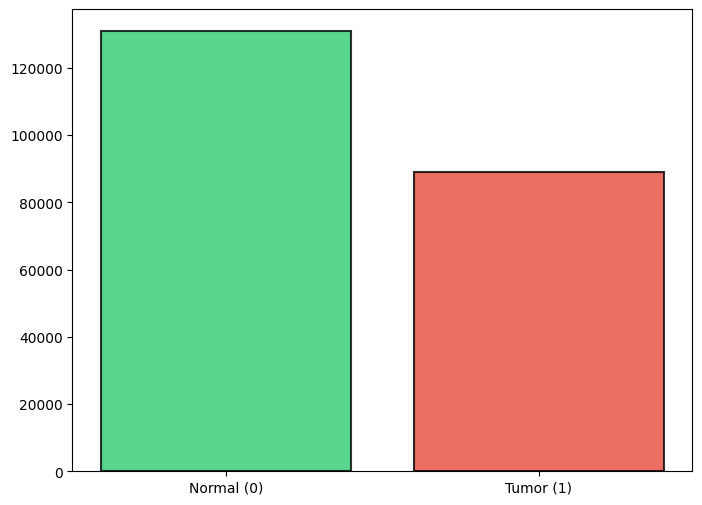

In [3]:
# Train labels
import seaborn as sns
print(f"Total training images: {len(train_labels)}")
# Bar Chart
plt.figure(figsize=(8, 6))
label_counts = train_labels['label'].value_counts().sort_index()

bars = plt.bar(['Normal (0)', 'Tumor (1)'], 
                label_counts.values,
                color=['#2ecc71', '#e74c3c'],
                alpha=0.8,
                edgecolor='black',
                linewidth=1.5)

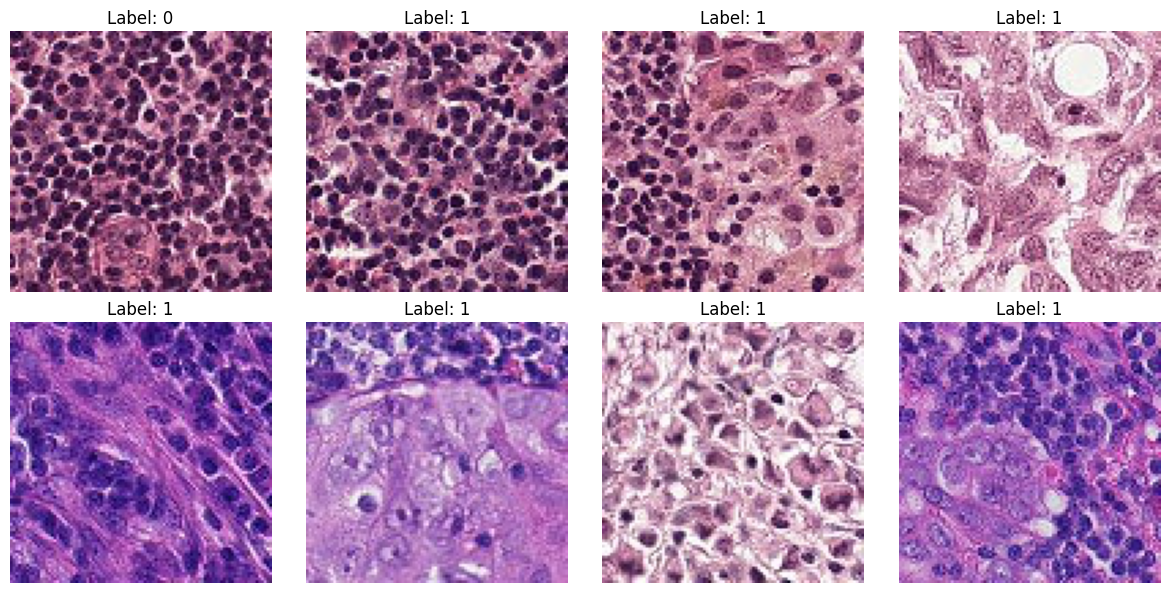

Image sizes (width, height): {(96, 96)}
Image shapes (height, width, channels): {(96, 96, 3)}


In [4]:
# View size of images and image sample
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
sample = train_labels.sample(n=8).reset_index()

sample = train_labels.sample(n=8).reset_index(drop=True)

sizes = []
shapes = []

# Create figure
plt.figure(figsize=(12, 6))

for idx, row in sample.iterrows():
    img_path = os.path.join(train_path, f"{row['id']}.tif")
    img = Image.open(img_path)
    
    # Get image sizes and shapes
    sizes.append(img.size)
    img_array = np.array(img)
    shapes.append(img_array.shape)
    
    # Plot image
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Image sizes (width, height):", set(sizes))
print("Image shapes (height, width, channels):", set(shapes))

### Image Cropping
We need to decide how to deal with the images. We have 96 x 96 images, but we need to only focus on the center piece (32 x 32). Let's start by creating a center crop of each image and then training our CNN on these cropped images.

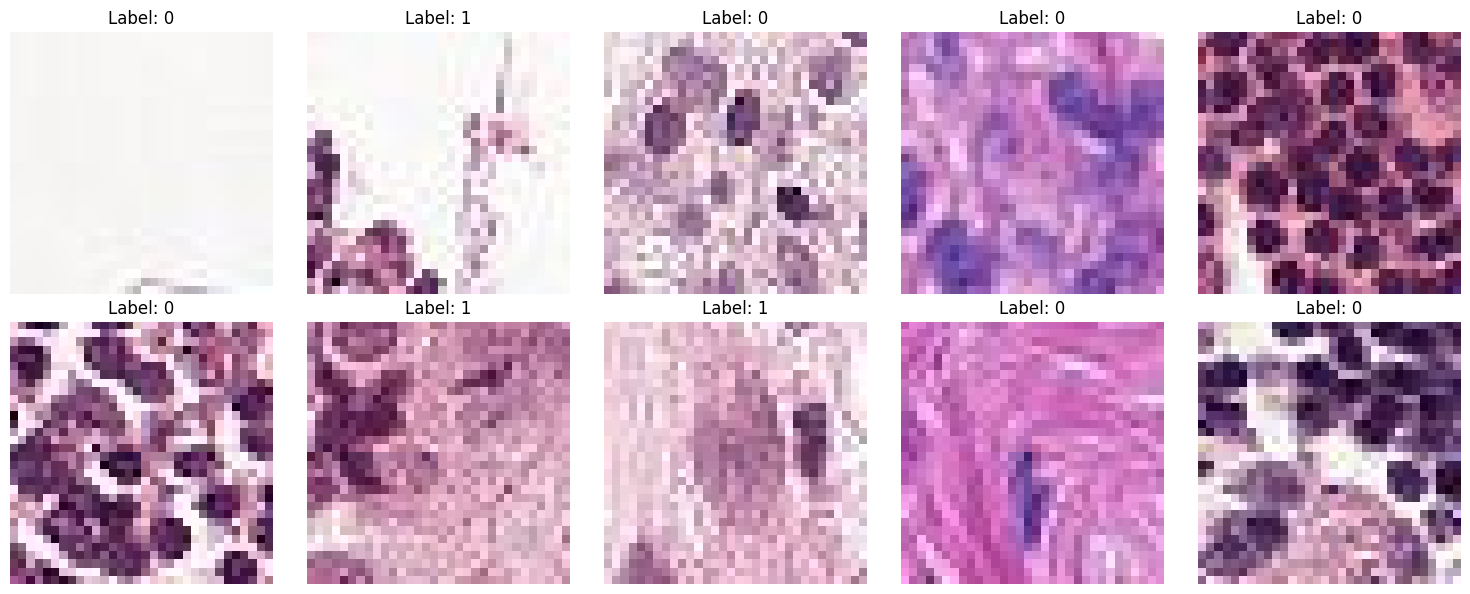

In [5]:
# Function to load and crop images
def load_and_crop_image(image_path, crop_size = 32):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Calculate center crop coordinates
    center = img.shape[0] // 2
    half_crop = crop_size // 2
    
    # Crop center 32x32 portion
    img_cropped = img[center-half_crop:center+half_crop, 
                      center-half_crop:center+half_crop]
    
    return img_cropped

# View Cropped Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    img_id = train_labels.iloc[i]['id']
    label = train_labels.iloc[i]['label']
    img_path = os.path.join(train_path, img_id + '.tif')
    
    img_cropped = load_and_crop_image(img_path)
    
    axes[i].imshow(img_cropped)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



### Load and Preprocess Training Data

In [6]:
def load_train_data(train_labels, train_path, crop_size=32, sample_size=None):
    if sample_size:
        train_labels = train_labels.sample(n=sample_size, random_state=42)
    
    images = []
    labels = []
    
    print("Loading training images...")
    for idx, row in tqdm(train_labels.iterrows(), total=len(train_labels)):
        img_path = os.path.join(train_path, row['id'] + '.tif')
        img = load_and_crop_image(img_path, crop_size)
        
        images.append(img)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

# Load a subset of data for faster training (adjust sample_size as needed)
X, y = load_train_data(train_labels, train_path, crop_size=32, sample_size=20000)

# Normalize pixel values
X = X.astype('float32') / 255.0

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Loading training images...


100%|██████████| 20000/20000 [03:25<00:00, 97.53it/s] 


Training set shape: (16000, 32, 32, 3)
Validation set shape: (4000, 32, 32, 3)


### CNN Architecture
Now we are building the 32 x 32 CNN model. Based on our lectures, I will start with using (3x3) fitlers, use batch normalization, and Max Pooling. 

In [7]:
def build_cnn():
    
    model = keras.Sequential([

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),  # 32->16
        layers.Dropout(0.25),
        

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),  # 16->8
        layers.Dropout(0.25),
        

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),  # 8->4
        layers.Dropout(0.25),
        

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),  # 4x4x256 -> 256
        
        # Dense
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Full Model Implementation
We will split the data and create our CNN model to run on our training data

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753763369.622181      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,209,633 (4.61 MB)

 Trainable params: 1,207,457 (4.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753763379.655817      61 service.cc:148] XLA service 0x7853d8003090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753763379.656775      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753763380.595084      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6984 - auc: 0.7702 - loss: 0.7155

I0000 00:00:1753763387.099035      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7195 - auc: 0.7730 - loss: 0.6347 - val_accuracy: 0.7258 - val_auc: 0.8542 - val_loss: 0.6606
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7676 - auc: 0.8270 - loss: 0.5085 - val_accuracy: 0.7740 - val_auc: 0.8101 - val_loss: 0.5334
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7861 - auc: 0.8383 - loss: 0.4835 - val_accuracy: 0.7937 - val_auc: 0.8646 - val_loss: 0.4646
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7885 - auc: 0.8527 - loss: 0.4650 - val_accuracy: 0.7993 - val_auc: 0.8731 - val_loss: 0.4399
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7892 - auc: 0.8581 - loss: 0.4582 - val_accuracy: 0.6860 - val_auc: 0.7288 - val_loss: 0.7455
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8038 - auc: 0.8671 - loss: 0.4418 - val_accuracy: 0.6873 - val_auc: 0.6674 - val_loss: 0.7716
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 1

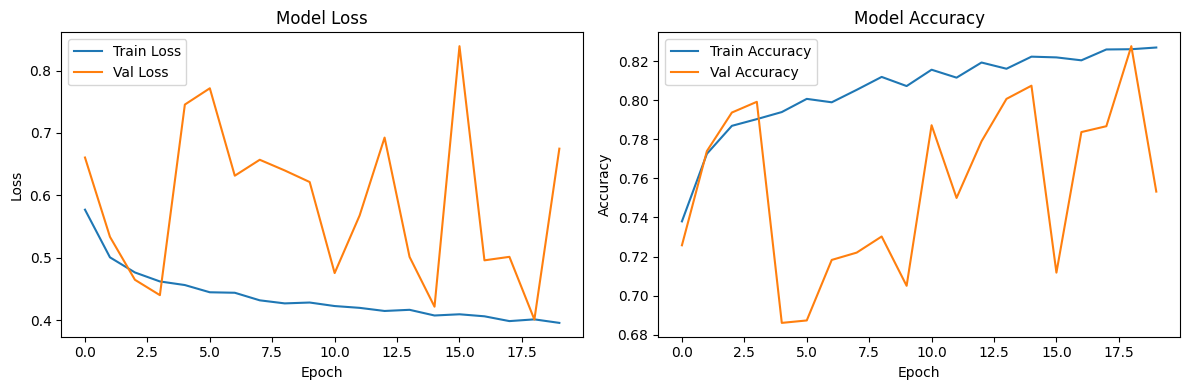

In [8]:
# Compile model
model = build_cnn()
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


### Results and Analysis
Running my initial model, I achieved a submission score of 0.6976. There is significant room for improvement. Taking a look at my model loss and model accuracy graphs from training, I have crazy spikes for my validation data. This validation volatility could be caused by the batch compilation issues or maybe my learning rate is too high. Let's try to fix this 

In [9]:
# Regularized model
def create_regularized_model():
    
    model = tf.keras.Sequential([
        # Add L2 regularization to conv layers
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Increased dropout
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(64, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Use cosine annealing learning rate
def cosine_annealing_schedule(epoch, lr):
    """Cosine annealing schedule"""
    epochs = 30
    lr_max = 0.001
    lr_min = 0.00001
    
    lr = lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    return lr

# 3. Add data augmentation mixup
def mixup_augmentation(images, labels, alpha=0.2):
    """Mixup augmentation for better generalization"""
    batch_size = tf.shape(images)[0]
    
    # Random lambda
    lambda_val = tf.random.uniform([batch_size, 1, 1, 1], 0, 1)
    lambda_val = tf.maximum(lambda_val, 1 - lambda_val)
    
    # Random permutation
    indices = tf.random.shuffle(tf.range(batch_size))
    
    # Mix images and labels
    mixed_images = lambda_val * images + (1 - lambda_val) * tf.gather(images, indices)
    mixed_labels = lambda_val[:, 0, 0, 0] * labels + (1 - lambda_val[:, 0, 0, 0]) * tf.gather(labels, indices)
    
    return mixed_images, mixed_labels

# 4. Monitor gradient flow
class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if gradients are exploding
        weights = self.model.trainable_weights
        gradients = tf.gradients(self.model.total_loss, weights)
        
        gradient_norms = [tf.norm(g) for g in gradients if g is not None]
        max_norm = tf.reduce_max(gradient_norms)
        
        if max_norm > 10:
            print(f"Warning: Large gradient norm {max_norm:.2f} at epoch {epoch}")

Let's compile this new model and compare

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.7464 - auc_1: 0.8017 - loss: 1.2170 - val_accuracy: 0.6072 - val_auc_1: 0.8608 - val_loss: 0.9088
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7904 - auc_1: 0.8424 - loss: 0.6566 - val_accuracy: 0.8020 - val_auc_1: 0.8671 - val_loss: 0.5667
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7831 - auc_1: 0.8469 - loss: 0.5782 - val_accuracy: 0.6700 - val_auc_1: 0.7360 - val_loss: 0.7853
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7968 - auc_1: 0.8521 - loss: 0.5495 - val_accuracy: 0.7575 - val_auc_1: 0.8647 - val_loss: 0.5628
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7967 - auc_1: 0.8547 - loss: 0.5368 - val_accuracy: 0.6660 - val_auc_1: 0.8467 - val_loss: 0.6613
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7917 - auc_1: 0.8477 - loss: 0.5380 - val_accuracy: 0.6805 - val_auc_1: 0.7864 - val_loss: 0.6294
Epoch 7/2

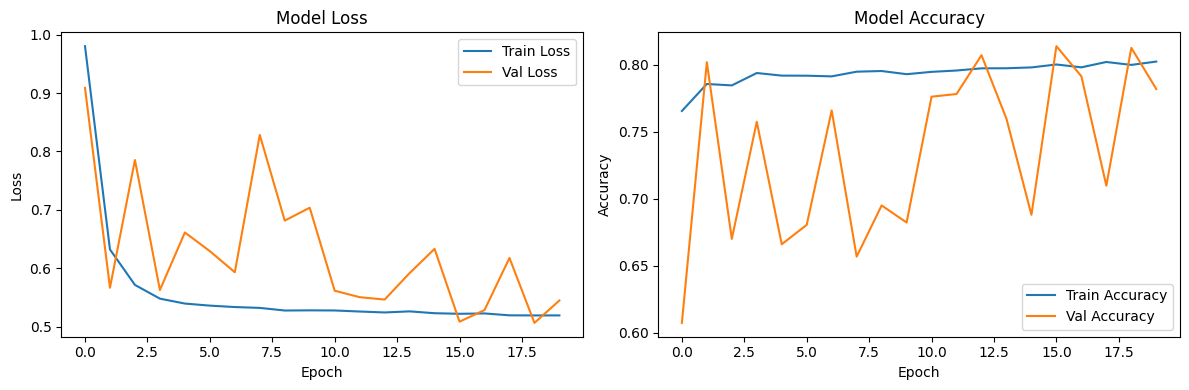

In [10]:
# Compile model
model2 = create_regularized_model()
model2.summary()

# Compile with label smoothing
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Better callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min'
    ),
    tf.keras.callbacks.LearningRateScheduler(cosine_annealing_schedule),
]

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)


# Train model
history2 = model2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history2.history['loss'], label='Train Loss')
ax1.plot(history2.history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history2.history['accuracy'], label='Train Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

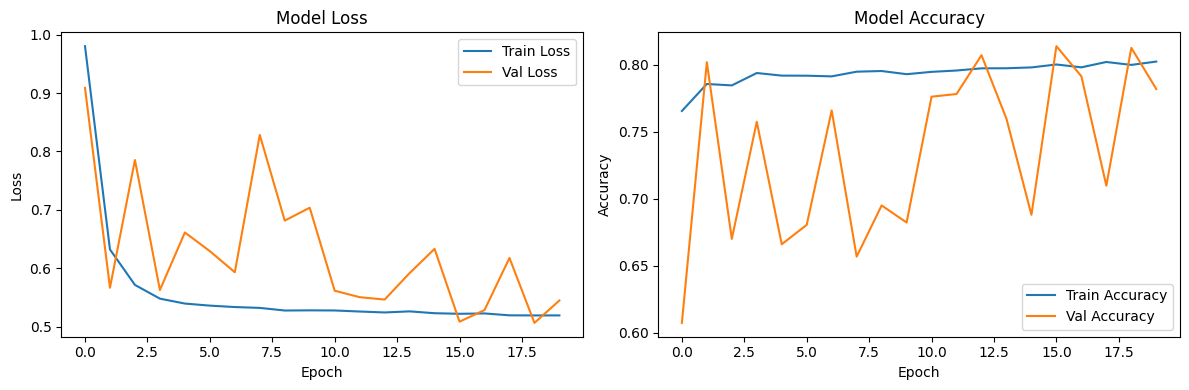

In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history2.history['loss'], label='Train Loss')
ax1.plot(history2.history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history2.history['accuracy'], label='Train Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

### Make Predictions on Test Set


Now I take the better model set-up and make predictions on the test set

In [12]:
# Load and predict on test data
def load_test_data(test_path, crop_size=32):
    """Load test images"""
    test_images = []
    test_ids = []
    
    print("Loading test images...")
    for filename in tqdm(sorted(os.listdir(test_path))):
        if filename.endswith('.tif'):
            img_path = os.path.join(test_path, filename)
            img = load_and_crop_image(img_path, crop_size)
            test_images.append(img)
            test_ids.append(filename.replace('.tif', ''))
    
    return np.array(test_images), test_ids

# Load test data
X_test, test_ids = load_test_data(test_path, crop_size=32)
X_test = X_test.astype('float32') / 255.0

print(f"Test set shape: {X_test.shape}")

# Make predictions
predictions = model2.predict(X_test, batch_size=32, verbose=1)
predictions = predictions.flatten()

# Use threshold 0.5 to make binary prediction
#predictions_binary = (predictions_prob >= 0.5).astype(int)


Loading test images...


100%|██████████| 57458/57458 [07:36<00:00, 125.84it/s]


Test set shape: (57458, 32, 32, 3)
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


### Submission File


Sample predictions:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
5  725dabe6ecccc68b958a2c7dd75bcbf362c7cb03      0
6  aa0307865281d4484ddf8c637c348292968b93a7      0
7  f4e5dc9c949920f1b3362982e15e99bf6f3ef83b      0
8  95e08c9cedc28a9b4a86f4fc1e06c1972134be08      0
9  ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb      0

Sample predictions:
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      0
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4  000270442cc15af719583a8172c87cd2bd9c7746      0
5  000309e669fa3b18fb0ed6a253a2850cce751a95      0
6  000360e0d8358db520b5c7564ac70c5706a0b

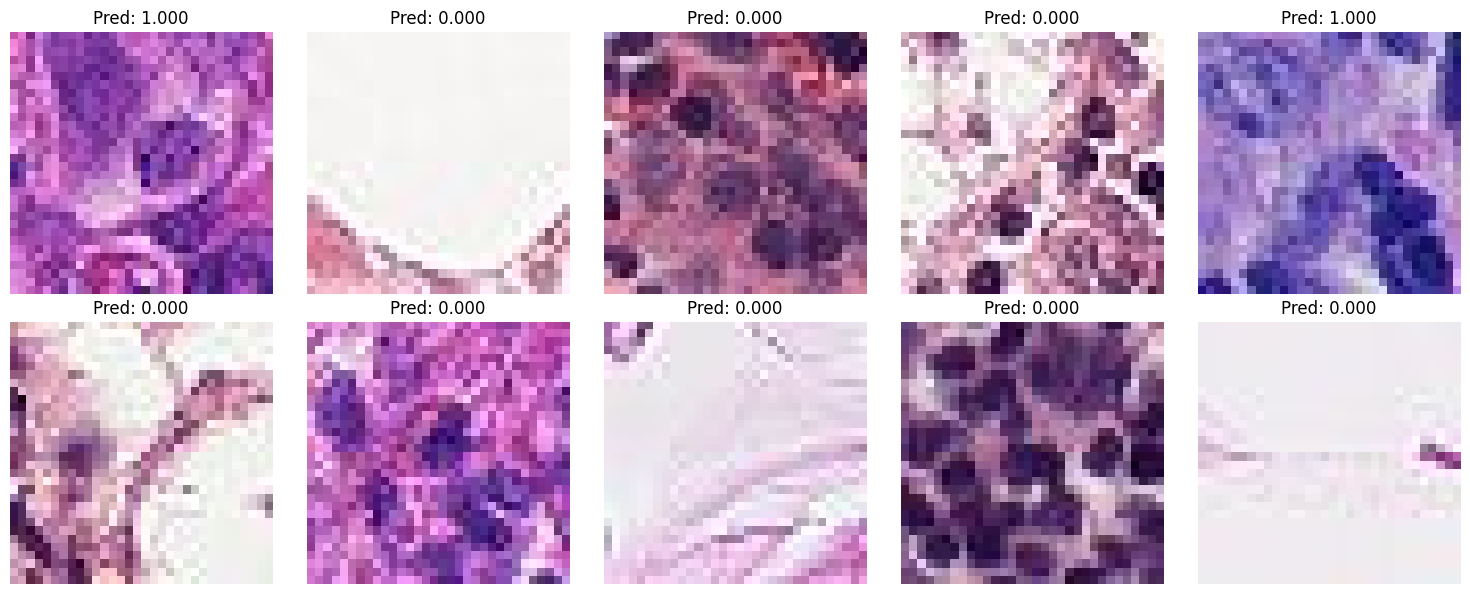

In [13]:
predictions_binary = (predictions >= 0.5).astype(int)

# Submission sample view
sample_sub = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
print("\nSample predictions:")
print(sample_sub.head(10))

# Create Submissions
submission = pd.DataFrame({
    'id': test_ids,
    'label': predictions_binary
})
# Display sample predictions
print("\nSample predictions:")
print(submission.head(10))

# Save submission
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission file created with {len(submission)} predictions")

# Visualize some test predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[idx])
    axes[i].set_title(f'Pred: {predictions_binary[idx]:.3f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 

## Conclusion
This notebook successfully viewed cancer image data, processed the data for training, created CNN architecture, and performed some validation analysis and optimization. My optimization techniques did not seem to improve my score that significantly. I believe the biggest issue I had was my initial cropping of my data. For future work, I would choose an alternative method than hard cropping all of the images to 32 x 32. Perhaps there is a way for a model to put more emphasis on the middle region, or you could even combine the cropped model with another one for better performance. Overall, this project helped me understand what CNNs can do for analyzing images.